# Problem 2: Sneaker vs Sandal Image Classification

In [146]:
import os
import numpy as np
import pandas as pd

import sklearn.linear_model
import sklearn.metrics
import sklearn.pipeline

from cross_validation import train_models_and_calc_scores_for_n_fold_cv
from performance_metrics_for_proba_predictions import calc_mean_binary_cross_entropy_from_probas

from tabulate import tabulate

In [147]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', style='whitegrid', font_scale=1.25)

In [148]:
SEED = 0
N_FOLDS_CV = 5
C_grid = np.logspace(-9, 6, 31)

In [149]:
DATA_DIR = 'data_sneaker_vs_sandal/'
x_tr_M = np.loadtxt(os.path.join(DATA_DIR, 'x_train.csv'), delimiter=',', skiprows=1)
x_te_N = np.loadtxt(os.path.join(DATA_DIR, 'x_test.csv'), delimiter=',', skiprows=1)

M_shape = x_tr_M.shape
N_shape = x_te_N.shape

M = M_shape[0]
N = N_shape[0]

y_tr_M = np.loadtxt(os.path.join(DATA_DIR, 'y_train.csv'), delimiter=',', skiprows=1)

# here I will do the split 90% for training (cv) and 10% for testing
random_state = np.random.RandomState(int(SEED))
shuffled_row_ids = random_state.permutation(M)

percentage_training = 0.9
M_prime = int(M * percentage_training)

indices = np.random.permutation(x.shape[0])
training_idx, test_idx = shuffled_row_ids[:M_prime], shuffled_row_ids[M_prime:]
training_x_tr, test_x_tr = x_tr_M[training_idx,:], x_tr_M[test_idx,:]

training_y_tr, test_y_tr = y_tr_M[training_idx], y_tr_M[test_idx]

print(training_x_tr.shape, test_x_tr.shape)
print(training_y_tr.shape, test_y_tr.shape)

(10800, 784) (1200, 784)
(10800,) (1200,)


In [152]:
from tabulate import tabulate

positive_y_tr_M = np.count_nonzero(training_y_tr == 1)
positive_y_te_M = np.count_nonzero(test_y_tr == 1)

table = [['total number of examples', M_prime, M - M_prime],
        ['number of positive examples', positive_y_tr_M, positive_y_te_M],
        ['fraction of positive examples', np.around(positive_y_tr_M/M_prime, 3), np.around(positive_y_te_M/(M-M_prime), 3)]]

print(tabulate(table, headers=['', 'train', 'test']))

                                 train      test
-----------------------------  -------  --------
total number of examples       10800    1200
number of positive examples     5401     599
fraction of positive examples      0.5     0.499


## Method 0: Baseline
Baseline: raw pixel features, fed into a Logistic Regression classifier
- You should use sklearn.linear_model.LogisticRegression
- You should carefully justify all hyperparameters, and select at least one complexity hyperparameter via grid search

In [153]:
def make_poly_logistic_regr_pipeline(C=1):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         #('rescaler', sklearn.preprocessing.MinMaxScaler()),
         #('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.LogisticRegression(C=C, solver='lbfgs', max_iter=1000)) #could use also penalty='l1' 
        ])
    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

In [154]:
def c_grid_search_logistic_regr(xs):
    #C_grid = np.logspace(-9, 6, 31)

    # Store binary cross entropy (bce) for all C in C_grid;
    # So we can compare and select the best C in the future steps.
    tr_bce_list = list()
    va_bce_list = list()
    #te_bce_list = list()

    # Store the error rate: Fraction of examples that are mis-classified (using threshold=0.5)
    # (We visualize it later, but don't use it in the report).
    # Remember, we justified using BCE for training our classifier by saying
    # it provides an *upper bound* on the error rate.
    tr_err_list = list()
    va_err_list = list()
    #te_err_list = list()

    for C in C_grid:
        pipeline = make_poly_logistic_regr_pipeline(C)
       
        
        tr_error, valid_error, tr_bce, valid_bce = train_models_and_calc_scores_for_n_fold_cv(pipeline, xs, training_y_tr, N_FOLDS_CV, SEED)

        # print('C = ', C)
        # print('---tr_error---', tr_error)
        # print('---valid_error---', valid_error)
        # print('---tr_bce---', tr_bce)
        # print('---valid_bce---', valid_bce)

        # print('------------------------------------')


        err_tr = np.mean(tr_error)
        err_va = np.mean(valid_error)

        bce_tr = np.mean(tr_bce)
        bce_va = np.mean(valid_bce)

        # print('---err_tr---', err_tr)
        # print('---err_va---', err_va)
        # print('---bce_tr---', bce_tr)
        # print('---bce_va---', bce_va)

        # print('>>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<<')

        tr_err_list.append(err_tr) # Error rate for training set. 
        va_err_list.append(err_va) # Error rate for validation set.

        # Save bce for future selection on Models.
        tr_bce_list.append(bce_tr) 
        va_bce_list.append(bce_va)
        
    return tr_err_list, va_err_list, tr_bce_list, va_bce_list



In [155]:
def plot_errors(tr_err_list, va_err_list, tr_bce_list, va_bce_list):
    plt.plot(np.log10(C_grid), tr_bce_list, 'b.-', label='train binary cross entropy')
    plt.plot(np.log10(C_grid), va_bce_list, 'r.-', label='valid binary cross entropy')

    plt.plot(np.log10(C_grid), tr_err_list, 'b:', label='train err')
    plt.plot(np.log10(C_grid), va_err_list, 'r:', label='valid err')

    plt.ylabel('error')
    plt.xlabel("log_{10} C");
    plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
    plt.ylim([0, 0.7]);

I am selecting the hyperparameter C via grid search. I used these valuse for C: C_grid = np.logspace(-9, 6, 31). now I will choose the model with the smallest cross entropy loss on the validation set.

In [156]:
def best_c(va_bce_list):
    # TODO Find the best C with the smallest cross entropy loss on the validation set
    idx_best_C = np.argmin(va_bce_list)
    #print(idx_best_C__lrF2)
    best_C_lr= C_grid[idx_best_C]

    print("Best C value for lr model:", best_C_lr)
    print("Best log_10(C) value for lr model:", np.log10(best_C_lr))
    
    return best_C_lr

In [157]:

# let's see out of curiosity which model minimizes the validation error rate

# TODO Find the best C with the smallest cross entropy loss on the validation set
idx_best_C_err_valid_rate = np.argmin(va_err_list)
#print(idx_best_C__lrF2)
best_C_lr_err_valid_rate= C_grid[idx_best_C_err_valid_rate]

print("Best C value for lr model:", best_C_lr_err_valid_rate)
print("Best log_10(C) value for lr model:", np.log10(best_C_lr_err_valid_rate))

Best C value for lr model: 1000.0
Best log_10(C) value for lr model: 3.0


In [158]:
# I am avoiding overfitting since I am choosing the model that minimizes the validation error not the training error.
# I am also doing CV, which does not overestimate the error rate as it happens in the validation set approach.

In [163]:
# retrieving the model with the best C for model 0
def best_c_model_error(best_C_lr, xs):
    best_C_model_0 = sklearn.linear_model.LogisticRegression(C=best_C_lr, solver='lbfgs', max_iter=1000)
    best_C_model_0.fit(xs, training_y_tr)


    yhat_tr = best_C_model_0.predict_proba(xs)[:,1]
    yhat_te = best_C_model_0.predict_proba(test_x_tr)[:,1]


    #print("train error rate model 0 =", sklearn.metrics.zero_one_loss(y_tr_M, yhat_tr >= 0.5))
    tr_error_rate = sklearn.metrics.zero_one_loss(training_y_tr, yhat_tr >= 0.5)
    te_error_rate = sklearn.metrics.zero_one_loss(test_y_tr, yhat_te >= 0.5)
    #print("train bce model 0 =", calc_mean_binary_cross_entropy_from_probas(y_tr_M, yhat_tr))
    tr_bce = calc_mean_binary_cross_entropy_from_probas(training_y_tr, yhat_tr)
    te_bce = calc_mean_binary_cross_entropy_from_probas(test_y_tr, yhat_te)
    return best_C_model_0, tr_error_rate, tr_bce, te_error_rate, te_bce

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

Best C value for lr model: 0.31622776601683794
Best log_10(C) value for lr model: -0.5
Best C value for lr model (MODEL 0 - Baseline): 0.31622776601683794
Training error rate 0.4790416666666667
Validation error rate 0.48291666666666666
Training BCE 0.9999797450359569
Validation BCE 1.0000549643386765
train error rate model 0 (all training set)= 0.029916666666666702
train bce model 0 (all training set)= 0.12866163041996062
                                         model 0
-------------------------------------  ---------
best C                                 0.316228
CV training error rate                 0.479042
CV validation error rate               0.482917
CV Training BCE                        0.99998
CV Validation BCE                      1.00005
train error rate (whole training set)  0.0299167
train bce (whole training set)         0.128662


/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


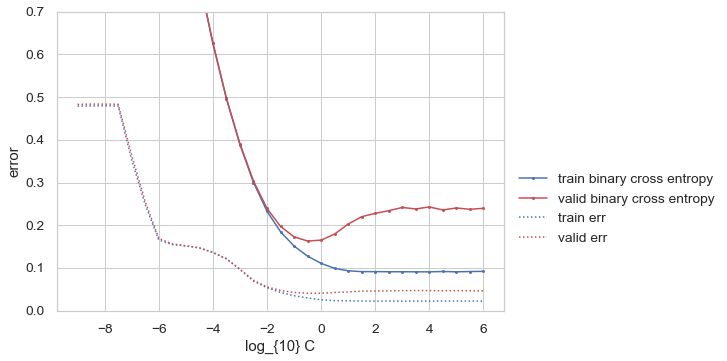

In [92]:
tr_err_list, va_err_list, tr_bce_list, va_bce_list = c_grid_search_logistic_regr(training_x_tr)

#print(C_grid.shape)
#print(tr_bce_list.shape)

plot_errors(tr_err_list, va_err_list, tr_bce_list, va_bce_list)

best_C_lr = best_c(va_bce_list)

best_C_model_0, tr_error_rate, tr_bce, te_error_rate, te_bce = best_c_model_error(best_C_lr, training_x_tr)

print("Best C value for lr model (MODEL 0 - Baseline):", best_C_lr)
print("Training error rate", tr_err_list[idx_best_C_err_valid_rate])
print("Validation error rate", va_err_list[idx_best_C_err_valid_rate])
print("Training BCE", tr_bce_list[idx_best_C_err_valid_rate])
print("Validation BCE", va_bce_list[idx_best_C_err_valid_rate])

print("train error rate model 0 (all training set)=", sklearn.metrics.zero_one_loss(training_y_tr, yhat_tr >= 0.5))
print("train bce model 0 (all training set)=", calc_mean_binary_cross_entropy_from_probas(training_y_tr, yhat_tr))


table = [
    ['best C', best_C_lr],
    ['CV training error rate', tr_err_list[idx_best_C_err_valid_rate]],
    ['CV validation error rate', va_err_list[idx_best_C_err_valid_rate]],
    ['CV Training BCE', tr_bce_list[idx_best_C_err_valid_rate]],
    ['CV Validation BCE', va_bce_list[idx_best_C_err_valid_rate]],
    ['train error rate (whole training set)', sklearn.metrics.zero_one_loss(training_y_tr, yhat_tr >= 0.5)],
    ['train bce (whole training set)', calc_mean_binary_cross_entropy_from_probas(training_y_tr, yhat_tr)]
]

print(tabulate(table, headers=['', 'model 0']))

Note that when I compute the training error rate and training bce on the whole training data, these error rates are slightly higher than when doing CV. This is due the variance of the validation set approach.

# Method 1:

In [160]:
# in order to find a nice transform function, I will look up which pixels had the most impact on the predictions.

#print(best_C_model_0.coef_)

coeff_28x28 = best_C_model_0.coef_.reshape((28, 28))

plt.imshow(coeff_28x28, cmap='RdYlBu', vmin=-0.5, vmax=0.5)

#plt.xlabel("iterations");
#plt.ylabel('log loss')

#plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
#plt.legend()
plt.colorbar()
plt.title('Learned Weight coefficients corresponding to the pixels of the original images')

ValueError: cannot reshape array of size 785 into shape (28,28)

In [165]:
def compute_results_model_on(xs, s):
    tr_err_list, va_err_list, tr_bce_list, va_bce_list = c_grid_search_logistic_regr(xs)

    #print(C_grid.shape)
    #print(tr_bce_list.shape)

    plot_errors(tr_err_list, va_err_list, tr_bce_list, va_bce_list)

    best_C_lr = best_c(va_bce_list)

    best_C_model_0, tr_error_rate, tr_bce, te_error_rate, te_bce = best_c_model_error(best_C_lr, xs)

    #print("Best C value for lr model (MODEL 0 - Baseline):", best_C_lr)
    #print("Training error rate", tr_err_list[idx_best_C_err_valid_rate])
    #print("Validation error rate", va_err_list[idx_best_C_err_valid_rate])
    #print("Training BCE", tr_bce_list[idx_best_C_err_valid_rate])
    #print("Validation BCE", va_bce_list[idx_best_C_err_valid_rate])

    #print("train error rate model 0 (all training set)=", sklearn.metrics.zero_one_loss(y_tr_M, yhat_tr >= 0.5))
    #print("train bce model 0 (all training set)=", calc_mean_binary_cross_entropy_from_probas(y_tr_M, yhat_tr))


    table = [
        ['best C', best_C_lr],
        ['CV training error rate', tr_err_list[idx_best_C_err_valid_rate]],
        ['CV validation error rate', va_err_list[idx_best_C_err_valid_rate]],
        ['CV Training BCE', tr_bce_list[idx_best_C_err_valid_rate]],
        ['CV Validation BCE', va_bce_list[idx_best_C_err_valid_rate]],
        ['train error rate (whole training set)', tr_error_rate],
        ['train bce (whole training set)', tr_bce],
        ['test error rate', te_error_rate],
        ['test bce', te_bce]
    ]

    print(tabulate(table, headers=['', 'model ' + s]))

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

Best C value for lr model: 0.31622776601683794
Best log_10(C) value for lr model: -0.5
                                         model baseline model (plain logistic regr)
-------------------------------------  --------------------------------------------
best C                                                                    0.316228
CV training error rate                                                    0.016713
CV validation error rate                                                  0.0557407
CV Training BCE                                                           0.0701276
CV Validation BCE                                                         0.441578
train error rate (whole training set)                                     0.0298148
train bce (whole training set)                                            0.129764
test error rate                                                           0.0341667
test bce                                                                  0.1

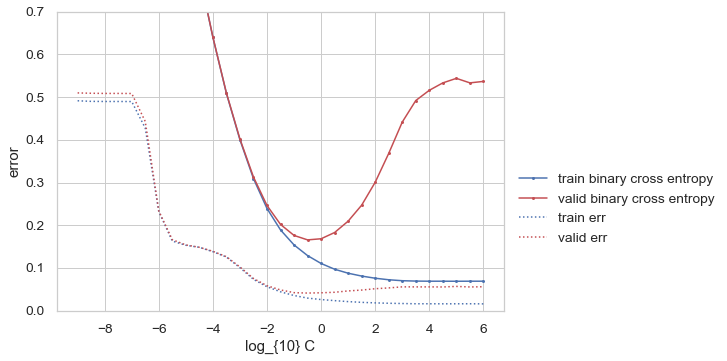

In [166]:
compute_results_model_on(training_x_tr, "baseline model (plain logistic regr)")

In [167]:
#sneakers shouldf be more beefy than sandals
# I expect that the number of pixels that are "on" (i.e. they are not 0.0) help distinguish sandals from sneakers
# I am going to create a new version of the x_tr_M, where each row will have an additional feature, the sum of the pixels that are "on". y_tr_M will remain the same

sum_on_feature = [np.sum(x)/784 for x in x_tr_M] # 28*28 = 784
print(np.asarray(sum_on_feature).shape)

sum_on_feature = np.asarray(sum_on_feature)
sum_on_feature = sum_on_feature.reshape((sum_on_feature.shape[0], 1))
x_tr_M_sum_on = np.hstack((x_tr_M, sum_on_feature))

print(x_tr_M.shape)
print(x_tr_M_sum_on.shape)

print(x_tr_M_sum_on[0:200, :])

compute_results_model_on(x_tr_M_sum_on, 'average luminosity per pixel')

(12000,)
(12000, 784)
(12000, 785)
[[0.         0.         0.         ... 0.         0.         0.16268926]
 [0.         0.         0.         ... 0.         0.         0.09949551]
 [0.         0.         0.         ... 0.         0.         0.20355441]
 ...
 [0.         0.         0.         ... 0.         0.         0.10843916]
 [0.         0.         0.         ... 0.         0.         0.18454334]
 [0.         0.         0.         ... 0.         0.         0.12624224]]


AssertionError: 

In [168]:
# now computing a new feature where I add 1 for each pixel that it is not 0, and averaging to the total number of pixels in the image, i.e. 28*28= 784

avg_non_zero_feature = []
for x in x_tr_M:
    columns_not_zero = x > 0.0
    #print(np.sum(columns_not_zero))
    avg_non_zero_feature.append(np.sum(columns_not_zero))

print(np.asarray(avg_non_zero_feature).shape)
print("feature before averaging", avg_non_zero_feature)

avg_non_zero_feature = np.asarray(avg_non_zero_feature)
avg_non_zero_feature = avg_non_zero_feature/784
print("feature after averaging", avg_non_zero_feature)
avg_non_zero_feature = avg_non_zero_feature.reshape((avg_non_zero_feature.shape[0], 1))
print("feature after reshaping", avg_non_zero_feature)
x_tr_M_avg_non_zero = np.hstack((x_tr_M, avg_non_zero_feature))

print(x_tr_M.shape)
print(x_tr_M_avg_non_zero.shape)

print(x_tr_M_avg_non_zero[0:200, :])

compute_results_model_on(x_tr_M_avg_non_zero, 'average number of \"on\" pixels per image')

(12000,)
feature before averaging [248, 253, 314, 299, 239, 194, 132, 343, 271, 227, 257, 272, 367, 188, 115, 256, 253, 345, 211, 270, 323, 225, 197, 247, 260, 218, 259, 192, 212, 314, 242, 284, 200, 283, 254, 397, 239, 272, 315, 242, 225, 189, 223, 385, 233, 326, 348, 374, 258, 213, 296, 482, 367, 222, 385, 267, 385, 292, 219, 232, 283, 175, 308, 250, 222, 143, 240, 264, 161, 376, 144, 336, 242, 241, 287, 263, 221, 336, 247, 239, 198, 307, 236, 214, 298, 242, 247, 230, 253, 259, 222, 258, 253, 314, 262, 199, 232, 306, 211, 228, 220, 232, 206, 290, 285, 337, 290, 325, 325, 187, 286, 155, 226, 396, 220, 157, 282, 170, 268, 264, 301, 327, 146, 242, 249, 180, 259, 245, 223, 335, 235, 206, 222, 254, 269, 211, 307, 335, 243, 412, 242, 152, 210, 284, 331, 177, 272, 188, 364, 252, 328, 266, 282, 233, 150, 129, 279, 240, 194, 199, 249, 143, 229, 146, 329, 267, 234, 251, 342, 337, 130, 295, 272, 249, 227, 241, 168, 114, 227, 209, 277, 254, 236, 284, 422, 336, 325, 297, 372, 315, 191, 208, 251, 

AssertionError: 

In [111]:
# testing hstack
arr1 = np.asarray([1, 2, 3, 4, 5, 6]).reshape((3, 2))
print(arr1)
arr2 = np.asarray([4, 8, 5]).reshape((3, 1))
print(arr1.shape)
print(arr2.shape)
print(np.hstack((arr1, arr2)))

[[1 2]
 [3 4]
 [5 6]]
(3, 2)
(3, 1)
[[1 2 4]
 [3 4 8]
 [5 6 5]]


(12000,)
(12000, 784)
(12000, 785)
[[  0.   0.   0. ...   0.   0. 220.]
 [  0.   0.   0. ...   0.   0. 232.]
 [  0.   0.   0. ...   0.   0. 206.]
 ...
 [  0.   0.   0. ...   0.   0. 189.]
 [  0.   0.   0. ...   0.   0. 253.]
 [  0.   0.   0. ...   0.   0. 241.]]


/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

Best C value for lr model: 0.31622776601683794
Best log_10(C) value for lr model: -0.5
                                         model number of on pixels per image
-------------------------------------  -------------------------------------
best C                                                             0.316228
CV training error rate                                             0.5
CV validation error rate                                           0.5
CV Training BCE                                                    0.999867
CV Validation BCE                                                  0.999878
train error rate (whole training set)                              0.0299167
train bce (whole training set)                                     0.128662


/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


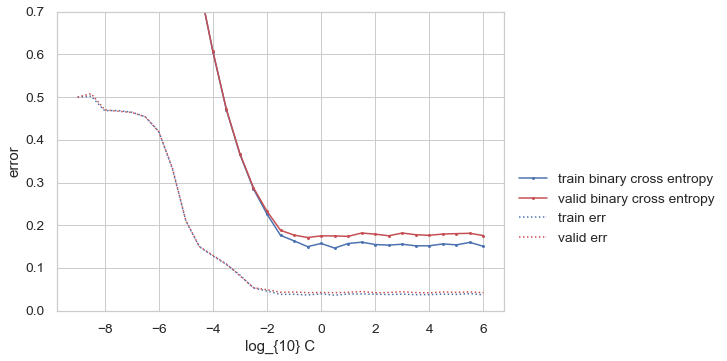

In [120]:
# now computing a new feature where I add 1 for each pixel that it is not 0, and WITHOUT averaging

non_zero_feature = list()
for x in x_tr_M:
    columns_not_zero = x > 0.0
    non_zero_feature.append(np.sum(columns_not_zero))

print(np.asarray(non_zero_feature).shape)

non_zero_feature = np.asarray(non_zero_feature)
non_zero_feature = non_zero_feature.reshape(non_zero_feature.shape[0], 1)
x_tr_M_non_zero = np.hstack((x_tr_M, non_zero_feature))

print(x_tr_M.shape)
print(x_tr_M_non_zero.shape)

print(x_tr_M_non_zero[100:200, :])

compute_results_model_on(x_tr_M_non_zero, 'number of on pixels per image')

In [125]:
# https://towardsdatascience.com/building-convolutional-neural-network-using-numpy-from-scratch-b30aac50e50a

l1_filter = np.zeros((2,3,3))

l1_filter[0, :, :] = np.array([[[-1, 0, 1],
                                   [-1, 0, 1],
                                   [-1, 0, 1]]])
l1_filter[1, :, :] = np.array([[[1,   1,  1],
                                   [0,   0,  0],
                                   [-1, -1, -1]]])

def conv_(img, conv_filter):
    filter_size = conv_filter.shape[1]
    result = np.zeros((img.shape))
    #Looping through the image to apply the convolution operation.
    for r in np.uint16(np.arange(filter_size/2.0, 
                          img.shape[0]-filter_size/2.0+1)):
        for c in np.uint16(np.arange(filter_size/2.0, 
                                           img.shape[1]-filter_size/2.0+1)):
            """
            Getting the current region to get multiplied with the filter.
            How to loop through the image and get the region based on 
            the image and filer sizes is the most tricky part of convolution.
            """
            curr_region = img[r-np.uint16(np.floor(filter_size/2.0)):r+np.uint16(np.ceil(filter_size/2.0)), 
                              c-np.uint16(np.floor(filter_size/2.0)):c+np.uint16(np.ceil(filter_size/2.0))]
            #Element-wise multipliplication between the current region and the filter.
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result) #Summing the result of multiplication.
            result[r, c] = conv_sum #Saving the summation in the convolution layer feature map.
            
    #Clipping the outliers of the result matrix.
    final_result = result[np.uint16(filter_size/2.0):result.shape[0]-np.uint16(filter_size/2.0), 
                          np.uint16(filter_size/2.0):result.shape[1]-np.uint16(filter_size/2.0)]
    return final_result

def conv(img, conv_filter):
    if len(img.shape) > 2 or len(conv_filter.shape) > 3: # Check if number of image channels matches the filter depth.
        if img.shape[-1] != conv_filter.shape[-1]:
            print("Error: Number of channels in both image and filter must match.")
            sys.exit()
    if conv_filter.shape[1] != conv_filter.shape[2]: # Check if filter dimensions are equal.
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')
        sys.exit()
    if conv_filter.shape[1]%2==0: # Check if filter diemnsions are odd.
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')
        sys.exit()

    # An empty feature map to hold the output of convolving the filter(s) with the image.
    feature_maps = np.zeros((img.shape[0]-conv_filter.shape[1]+1, 
                                img.shape[1]-conv_filter.shape[1]+1, 
                                conv_filter.shape[0]))

    # Convolving the image by the filter(s).
    for filter_num in range(conv_filter.shape[0]):
        print("Filter ", filter_num + 1)
        curr_filter = conv_filter[filter_num, :] # getting a filter from the bank.
        """ 
        Checking if there are mutliple channels for the single filter.
        If so, then each channel will convolve the image.
        The result of all convolutions are summed to return a single feature map.
        """
        if len(curr_filter.shape) > 2:
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.
            for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.
                conv_map = conv_map + conv_(img[:, :, ch_num], 
                                  curr_filter[:, :, ch_num])
        else: # There is just a single channel in the filter.
            conv_map = conv_(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
    return feature_maps # Returning all feature maps.

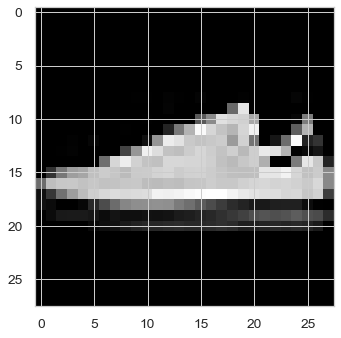

In [123]:

plt.imshow(x_tr_M[0].reshape(28,28), interpolation='nearest', vmin=0, vmax=1, cmap='gray')



Filter  1
Filter  2
(26, 26)


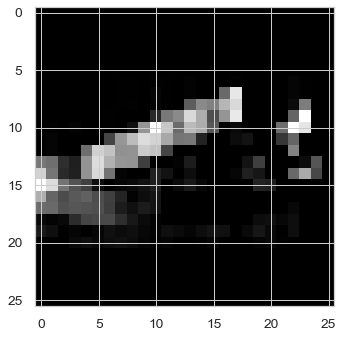

In [132]:
new_image = conv(x_tr_M[0].reshape(28,28), l1_filter)
print(new_image[:,:,0].shape)
plt.imshow(new_image[:,:,0], interpolation='nearest', vmin=0, vmax=1, cmap='gray')
